### Example notebook - Differential Gene Expression (Pathway Enrichment)

This notebook demonstrates reading from API and performing analysis of differential gene expression.
- title: "DGE-Pathways"
- author: "Margaret Paiva"
- author: "Jon Katz"
- date: "19/10/2021"
- output: R notebook

### 1. Dependencies

In [1]:
# cran packages
x <- c('dplyr',
       'data.table',
       'tidyr',   
       'tidyverse', 
       'tibble',
       'parallel',
       'DBI',
       'DT',
       'ggplot2')
# bioconductor packages
y <- c('fgsea', 
       'qusage')

In [2]:
# install cran packages
for (pkg in x) {
    if (!pkg %in% rownames(installed.packages())) {install.packages(pkg)}
}

In [3]:
# install bioconductor packages
if (!requireNamespace("BiocManager", quietly=TRUE))
    install.packages("BiocManager")
for (pkg in y) {
    if (!requireNamespace(pkg, quietly=TRUE)) {
        BiocManager::install(pkg)
    }
}

In [4]:
# load packages
load_lib <- function(x) {
    suppressPackageStartupMessages(library(x, character.only = TRUE))
}
invisible(lapply(c(x, y), load_lib))

### 2. Request data from API
Request data from API using the files at https://github.com/Champions-Oncology/Workspaces/tree/main/1starter_data_request.

This notebook used the following options to request data:

(This notebook used [this example list of genes](https://github.com/Champions-Oncology/Workspaces/blob/main/gene_list.csv). You may define your genes of interest in a .csv file and use it in the data requesting file.)

- table="expression",
- cancer_type=["Renal cell carcinoma", "Prostate", "Adenoid cystic carcinoma", "Breast", "Thyroid", "Testicular", "Hepatocellular", carcinoma", "Melanoma"],
- genes=list(genes_df['gene']),
- source = "PDX"
(For example, if you use the data_request.ipynb in Python, these are the options in the df, location = request_data() function.)

### 3. Read data

In [5]:
cancer_type <- "Breast" # select a cancer type you requested to investigate
# change to where you saved your .csv file and file name
df  <- fread("../data/pdx_expression_gene_list_multi_cancer.csv") %>% 
    filter(tumor_type == cancer_type)
df$gene  <- as.character(df$gene)
df$log.tpm  <- as.numeric(df$log.tpm)
head(df, 2)
print(dim(df))

gene,model,model_name,log.tpm,z,fold,tumor_type
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
ACSM3,CTG-3501,CTG-3501,2.7411490,-0.1693172,0.8765697,Breast
COPZ2,CTG-3501,CTG-3501,0.7995996,-0.9946150,0.1851744,Breast


[1] 48400     7


### 4. GSEA pathway enrichment analysis

GSEA needs a .gmt file with pathways and gene sets. The .gmt file used in this notebook is included in the [repo](https://github.com/Champions-Oncology/Workspaces). You may also download a different one from https://www.gsea-msigdb.org/gsea/msigdb/collections.jsp. 

In [6]:
pathways <- qusage::read.gmt("../pathways.gmt")

To use GSEA for pathway enrichment analysis, a ranking data with genes ranked by the t or z statistics must be provided. Here, we can extract the statistics from the API data. For your own research, you can calculate the t statistics between genes using the `log.tpm` column of the API data.

In [7]:
ranks <- df %>% 
  dplyr::select(gene, z) %>% 
  na.omit() %>%
  deframe()
head(ranks, 2)

ACSM3      COPZ2 
-0.1693172 -0.9946150

Now, we have everything we need to perform pathway enrichment analysis.

In [8]:
fgseaRes <- suppressWarnings(fgsea(pathways = pathways,
     stats = ranks,
     nperm = 1000))
head(fgseaRes, 2)

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
GOBP_MITOCHONDRIAL_GENOME_MAINTENANCE,0.026804124,0.036197574,0.9877683,1.314967,12,1,AKT3
GOBP_REPRODUCTION,0.002057613,0.005496058,0.9031364,3.511467,0,33,"FGFR2 , C3 , ETNK2 , FOLR1 , ACE , FOXC1 , DEFB1 , ADAMTS1 , COL9A3 , FOXA1 , FBLN1 , ANTXR1 , ARHGDIB , COL16A1 , BASP1 , BMP7 , EDN1 , BIRC3 , ADAM19 , CRIP1 , B4GALNT1, BIK , CADM1 , AREG , AXL , ANXA1 , DZIP1 , FOSL1 , ADM , BMP4 , AKR1C3 , ANG , CLDN4"


- ES – enrichment score
- NES – normalized enrichment score

### 5. Plot
This shows the GSEA enrichment scores for the selected cancer type. 

In [9]:
# Rank the pathways by the normalized enrichment scores
fgseaResTidy <- fgseaRes %>%
  as_tibble() %>%
  arrange(desc(NES))

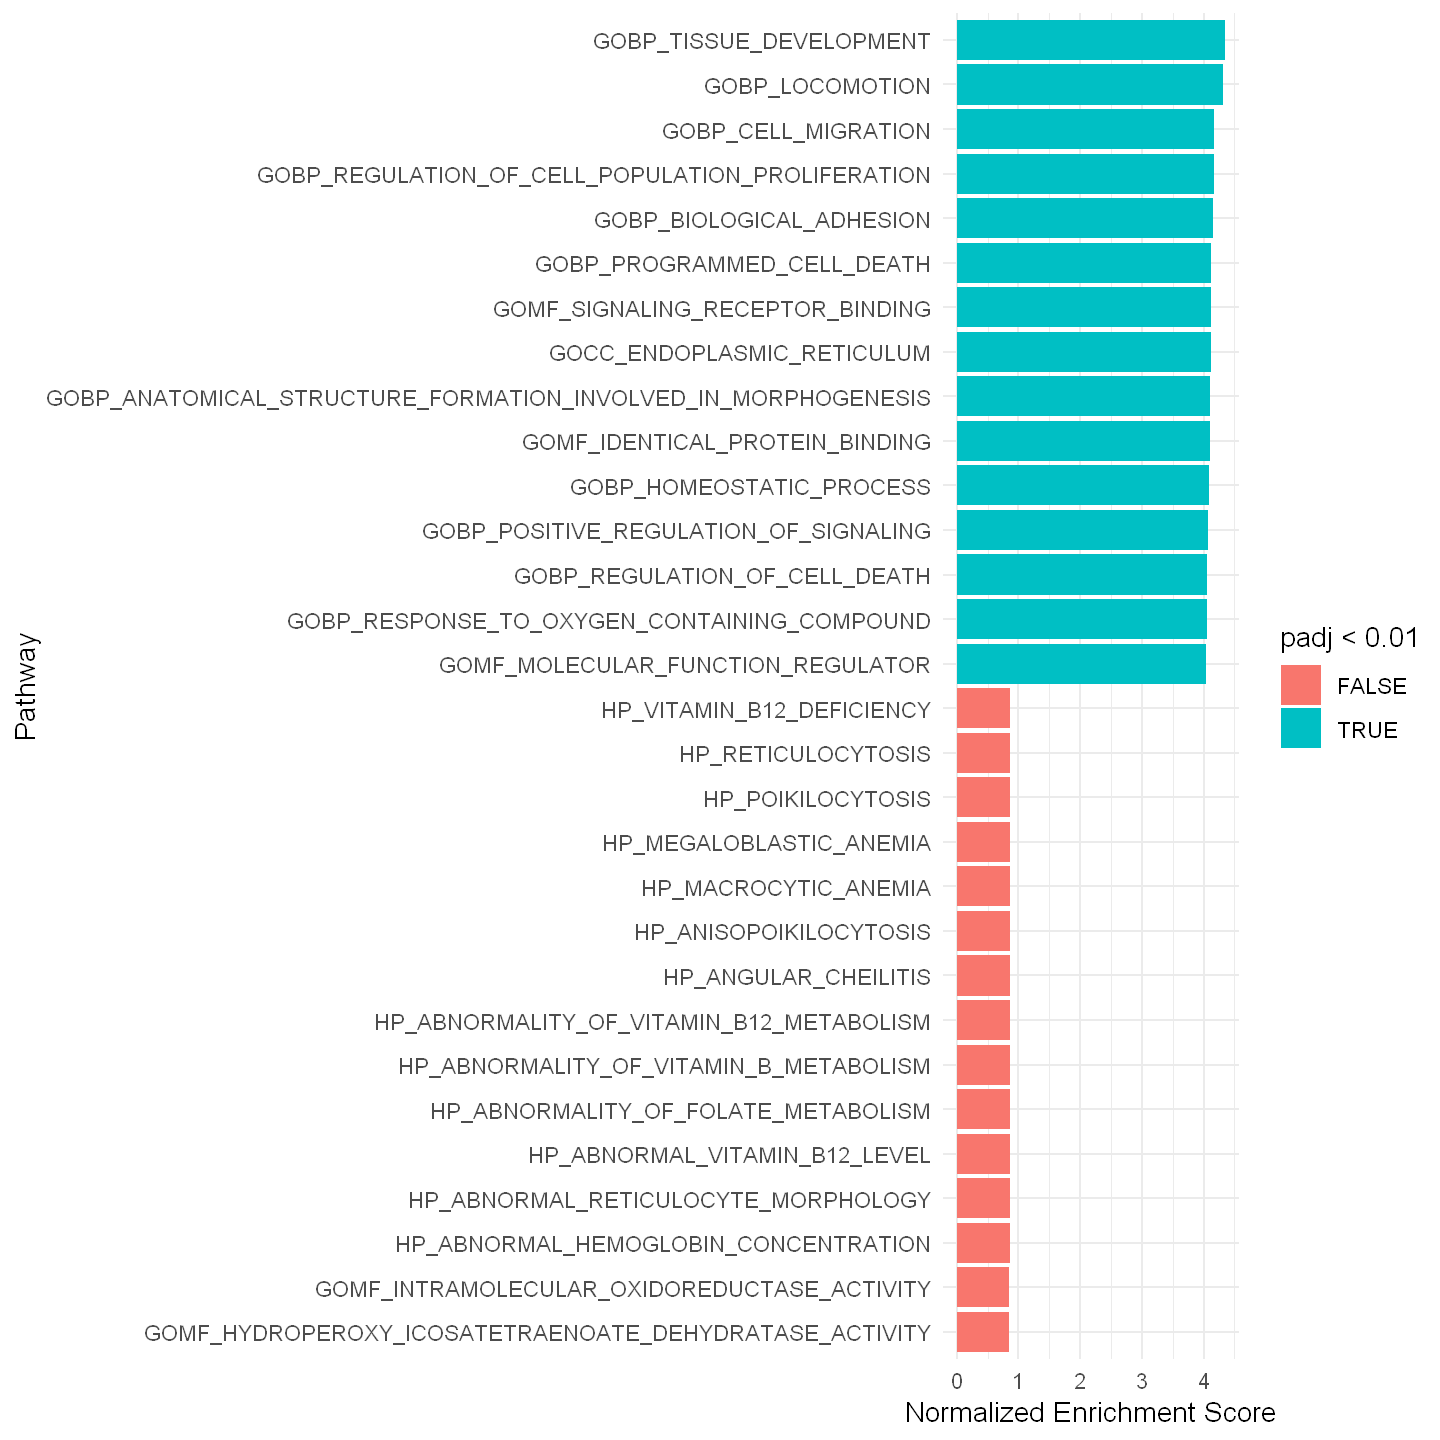

In [10]:
# Here, I rbind the top pathways and the bottom pathways to show the significant vs. the non-significant pathways
# You may want to pick only the top pathways to explore further
options(repr.plot.width=8, repr.plot.height=8, repr.plot.res=180) # Change plot size
ggplot(rbind(head(fgseaResTidy, 15), tail(fgseaResTidy, 15)), 
       aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.01)) + # set threshold for the adjusted P values
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score") + 
  theme_minimal()